# Analysis only

This dataset doesn't have a target column.  All this is just fun data exploration!

### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
pd.set_option('display.max_columns', None)

### Plotting helper function

In [61]:
def pretty_bar(data, ax, xlabel=None, ylabel=None, title=None, int_text=False):
    fig = sns.barplot(data.values, data.index, ax=ax)
    for i, v in enumerate(data.values):
        if int_text:
            ax.text(0.8,i,int(v),color='k',fontsize=14)
        else:
            ax.text(0.8,i,v,color='k',fontsize=14)
    ylabel != None and fig.set(ylabel=ylabel)
    xlabel != None and fig.set(xlabel=xlabel)
    title != None and fig.set(title=title)

### Load data

In [2]:
census = pd.read_csv("../../data/census/census_county.csv")

print("Shape of data", census.shape)
print("Columns:", census.columns)
census.head()

Shape of data (3220, 37)
Columns: Index(['CensusId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Citizen', 'Income',
       'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')


,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


### Removing missing rows with missing population values

In [3]:
census = census.drop(census[census.TotalPop == 0].index)

### Total race population

In [4]:
races = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']

for race in races:
    census[race + "_pop"] = (census[race] * census.TotalPop) / 100

### Race representation by state

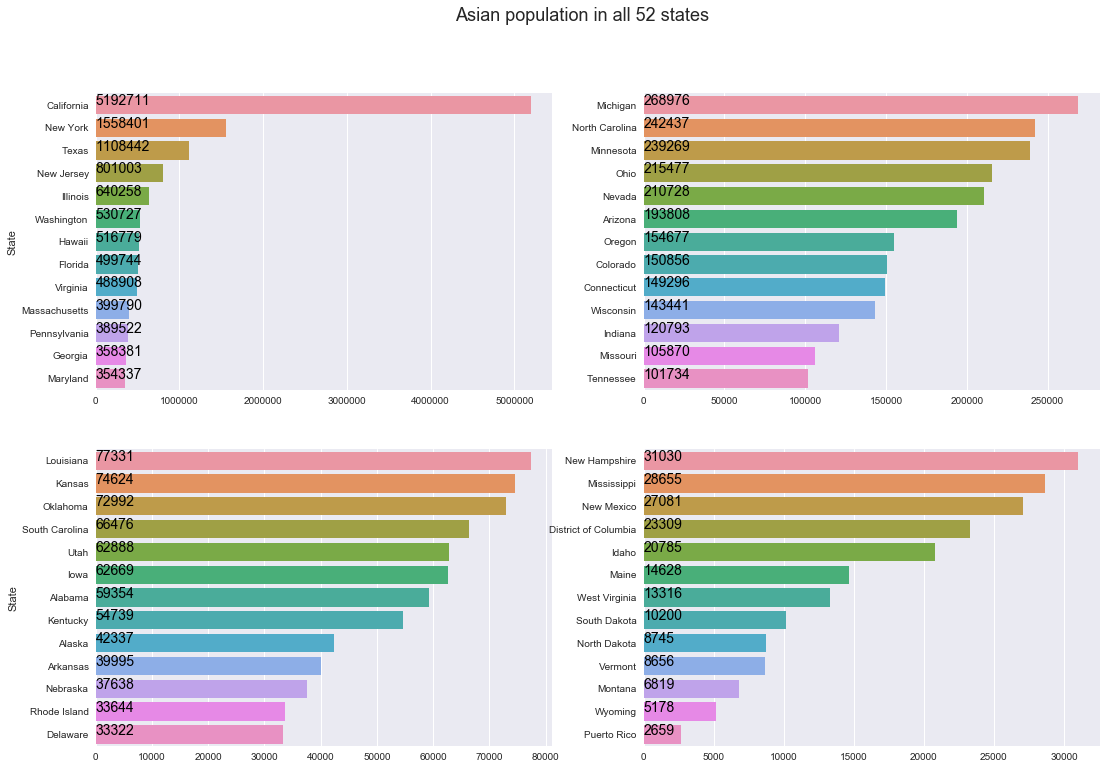

In [68]:
races = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']
race = races[4]

fig, axarr = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("{} population in all 52 states".format(race), fontsize=18)

race_pops = census.groupby("State")[race + "_pop"].sum().sort_values(ascending=False)

pretty_bar(race_pops.head(13), ax=axarr[0][0], int_text=True)
pretty_bar(race_pops.iloc[13:26], ax=axarr[0][1], int_text=True, ylabel="")
pretty_bar(race_pops.iloc[26:39], ax=axarr[1][0], int_text=True)
pretty_bar(race_pops.tail(13), ax=axarr[1][1], int_text=True, ylabel="")

### Race representation by county

I've never heard of Cook Illinois, but it has the highest Black Population and the 4th highest Hispanic Population.

Also LA seems to top the charts in terms of diversity

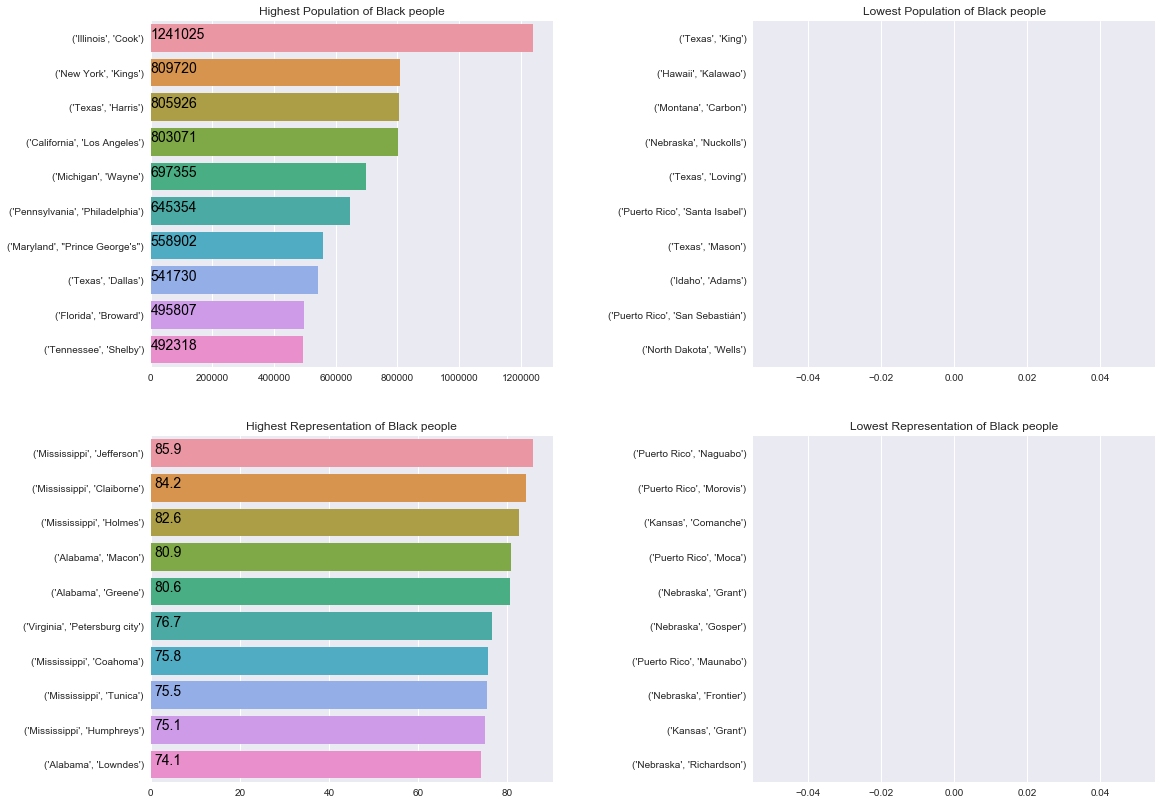

In [60]:
races = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']
race = races[2]

fig, axarr = plt.subplots(2, 2, figsize=(18,14))
fig.subplots_adjust(wspace=0.5)

race_pops = census.groupby(["State", "County"])[race + "_pop"].sum().sort_values(ascending=False)
race_reps = census.groupby(["State", "County"])[race].median().sort_values(ascending=False)

pretty_bar(race_pops.head(10), axarr[0][0], int_text=True, title="Highest Population of {} people".format(race))

data = race_pops.tail(10)
sns.barplot(x=data.values, y=data.index, ax=axarr[0][1]).set(ylabel="", title="Lowest Population of {} people".format(race))

pretty_bar(race_reps.head(10), axarr[1][0], title="Highest Representation of {} people".format(race))

data = race_reps.tail(10)
_ = sns.barplot(x=data.values, y=data.index, ax=axarr[1][1]).set(ylabel="", title="Lowest Representation of {} people".format(race))

### Unemployment among races

This has to be done indirectly (total_pop) x (fraction_unemployed) x (fraction_race).

There are clearly flaws with this (a really high native pop, but everyone unemployed is pacific), but maybe there will be interesting results.

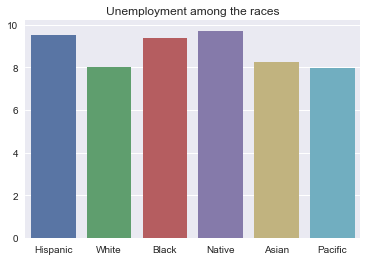

In [8]:
races = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']
unemployment = list()

for race in races:
    total_unemployed = (census.TotalPop * census.Unemployment * census[race] / 100).sum()
    total_population = census[race + "_pop"].sum()
    frac_unemployed = total_unemployed / total_population
    unemployment.append(frac_unemployed)
    
_ = sns.barplot(races, unemployment).set(title="Unemployment among the races")

### Correlation Map

Emphasis on the word correlation, not causation

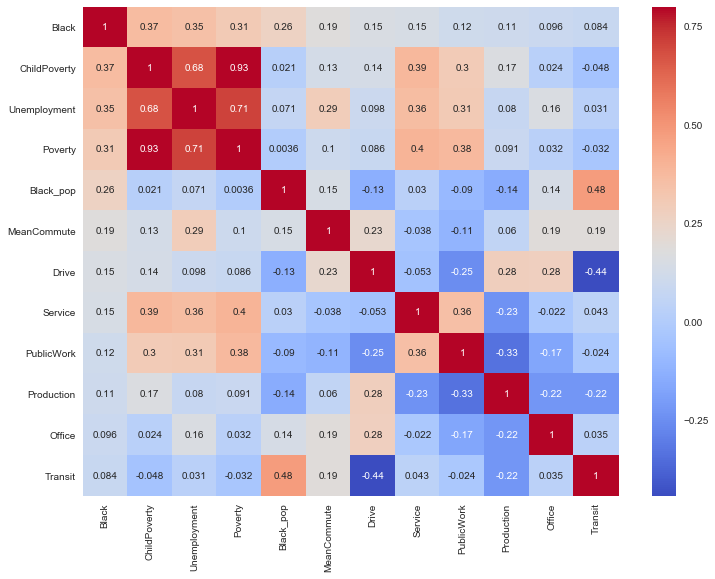

In [10]:
races = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']
race = races[2]

cols = census.corr().nlargest(12, race).tail(12).index

f, ax = plt.subplots(figsize=(12, 9))
_ = sns.heatmap(census[cols].corr(), vmax=.8, cmap = "coolwarm", annot=True)

### Child Poverty

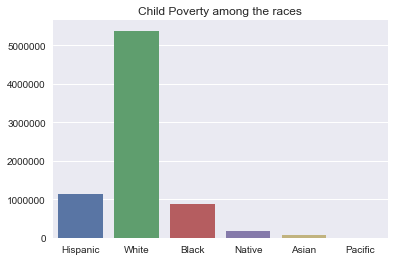

In [11]:
races = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']
child_poverty = list()

for race in races:
    child_poverty.append((census.ChildPoverty * census[race]).sum())
    
_ = sns.barplot(races, child_poverty).set(title="Child Poverty among the races")